# Important Graphs

In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems, SSMCMain.ModifiedMiCRM.GraphAnalysis

In [2]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto
using EnumX
using Random, Distributions
using FreqTables
using Graphs, Clustering
using MetaGraphsNext

In [3]:
using CairoMakie
using GLMakie
CairoMakie.activate!()

## Setup

In [4]:
import Base: copy

struct LinstabScanTester_SAR{F}
    ks::Vector{F}
    M1::Matrix{F}
    M::Matrix{F}
    threshold::F
    function LinstabScanTester_SAR(ks, N, threshold=2 * eps())
        M1 = Matrix{eltype(ks)}(undef, N, N)
        M = Matrix{eltype(ks)}(undef, N, N)
        new{eltype(ks)}(ks, M1, M, threshold)
    end
end
function LinstabScanTester_SAR(ks, p::AbstractMMiCRMParams, threshold=2 * eps())
    LinstabScanTester(ks, sum(get_Ns(p)), threshold)
end
function (lt::LinstabScanTester_SAR)(sp::AbstractSMMiCRMParams, ss)
    make_M1!(lt.M1, sp, ss)

    evals = eigvals(lt.M1)
    if any(l -> real(l) > 0., evals)
        return -1
    end

    for k in lt.ks
        lt.M .= lt.M1
        M1_to_M!(lt.M, get_Ds(sp), k)
        evals = eigvals!(lt.M)
        if any(l -> real(l) > lt.threshold, evals)
            return 1
        end
    end
    return 2
end
function copy(lst::LinstabScanTester_SAR)
    LinstabScanTester_SAR(lst.ks, size(lst.M)[1], lst.threshold)
end

copy (generic function with 470 methods)

In [5]:
# can add a copy of example_do_rg_run if we need more flexibility
function do_rg_run(rg, num_repeats, ks;
    extinctthreshold=1e-8,
    maxresidthreshold=1e-9,
    linstabthreshold=100 * eps(),
    return_interesting=false
)
    @time "Generating one params" sample_params = rg()
    flush(stdout)
    Ns, Nr = get_Ns(sample_params)
    N = Ns + Nr

    # prep for the run
    lst = LinstabScanTester_SAR(ks, N, linstabthreshold)

    rslts = fill(0, num_repeats)
    interesting_systems = []

    @tasks for i in 1:num_repeats
        @local llst = copy(lst)

        params = rg()

        result = 0
        interesting = false

        # numerically solve for the steady state
        u0 = ModifiedMiCRM.make_u0_onlyN(params)
        ssp = make_mmicrm_ss_problem(params, u0)
        ssps = solve(ssp, DynamicSS(QNDF());
            reltol=maxresidthreshold,
            #isoutofdomain=(u,_,_)-> any(x -> x < 0., u),
            maxiters=1000000
        )

        if SciMLBase.successful_retcode(ssps.retcode)
            warning = false
            maxresid = maximum(abs, ssps.resid)
            if maxresid > maxresidthreshold * 100
                @warn (@sprintf "maxresid reached is %g which is close to %g" maxresid (maxresidthreshold * 100))
                warning = true
            end

            if all(x -> abs(x) < extinctthreshold, ssps.u[1:Ns])
                result = -101 # gone extinct in nospace ss
            end

            linstab_result = llst(params, ssps.u)
            if !warning
                if linstab_result == 1
                    result = 2 # spatial instability
                    interesting = true
                elseif linstab_result == 2
                    result = 1 # stable
                else
                    result = 3 # stable but may be wrong
                end
            else
                if linstab_result == 1
                    result = -2 # spatial instability but may be wrong
                elseif linstab_result == 2
                    result = -1 # stable but may be wrong
                else
                    result = -3 # stable but may be wrong
                end
            end
        else
            result = -100
        end

        rslts[i] = result
        if return_interesting && interesting
            push!(interesting_systems, params)
        end

        # @printf "Run %d -> %d\n" i rslts[i]
        # flush(stdout)
    end

    if !return_interesting
        rslts
    else
        rslts, interesting_systems
    end
end

do_rg_run (generic function with 1 method)

In [6]:
function do_rg_run2(rg, num_repeats, kmax, Nks;
    maxresidthr=1e-7,            # will warn if ss residues are larger than this
    errmaxresidthr=1e6 * maxresidthr, # if above this will return error code
    extinctthr=maxresidthr / 10, # species below this value are considered extinct
    lszerothr=100 * eps(),      # values +- this are considered 0 in linstab analysis
    lspeakthr=lszerothr,
    # whether and which params to return for further examination (int <-> interesting)
    return_int=nothing,
    return_int_sss=true,
    # ss solver setup
    ode_solver=Rodas4(),
    tol=maxresidthr / 10,
    timelimit=nothing, # time limit for one solver run in seconds
    abstol=tol,
    reltol=tol,
    maxiters=100000,
    # passed to make_mmicrm_ss_problem
    kwargs...
)
    sample_params = rg()
    Ns, Nr = get_Ns(sample_params)
    N = Ns + Nr

    # handle interesting systems setup
    int_func = if isnothing(return_int)
        nothing
    elseif isa(return_int, Vector) || isa(return_int, Tuple)
        c -> c in return_int
    elseif isa(return_int, Function)
        return_int
    elseif return_int == :all
        c -> true
    else
        throw(ArgumentError("return_interesting needs to be either a list of codes or a custom function"))
    end

    solver_kwargs = (; maxiters, abstol, reltol)
    if !isnothing(timelimit)
        solver_kwargs = (; solver_kwargs..., callback=make_timer_callback(timelimit))
    end

    # setup ks for linstab analysis
    ks = LinRange(0.0, kmax, Nks)[2:end] # 0 is handled separately

    # setup the returned data containers
    rslts = fill(0, num_repeats)

    # these may not be used, skipping the if to not have them boxed
    int_lock = ReentrantLock()
    int_systems_to_return = typeof(sample_params)[]
    int_systems_sss = Vector{Float64}[]

    # the core of the function
    @localize solver_kwargs @tasks for i in 1:num_repeats
        # Prealloc variables in each thread (task)
        @local begin
            M1 = Matrix{Float64}(undef, N, N)
            M = Matrix{Float64}(undef, N, N)
            mrls = Vector{Float64}(undef, length(ks))
        end

        # Setup one random system
        params = rg()
        u0 = ModifiedMiCRM.make_u0_onlyN(params)
        ssp = make_mmicrm_ss_problem(params, u0; kwargs...)
        result = 0
        warning = false

        ######################################## 

        # numerically solve for the steady state
        ssps = solve(ssp, DynamicSS(ode_solver);
            isoutofdomain=(u,_,_)-> any(x -> x < 0., u), solver_kwargs...)

        # Check the solver
        if !SciMLBase.successful_retcode(ssps.retcode)
            result = -1000 # solver failed return code
            result -= Int(ssps.original.retcode)
            if ssps.original.retcode == ReturnCode.MaxTime
                @warn "Solver quit due to time limit being reached"
                flush(stderr)
            end
            @goto handle_result
        end
        # Check that the steady state is steady enough
        maxresid = maximum(abs, ssps.resid)
        if maxresid > errmaxresidthr
            @warn (@sprintf "maxresid reached is %g which is above the error threshold of %g" maxresid maxresidthr)
            result = -2000 # maxresid is way beyond any reasonable values
            @goto handle_result
        elseif maxresid > maxresidthr
            @warn (@sprintf "maxresid reached is %g > %g" maxresid maxresidthr)
            warning = true
        end

        # Check for a full extinction
        if all(x -> abs(x) < extinctthr, ssps.u[1:Ns])
            result = 101 # gone extinct in nospace ss
            @goto handle_result
        end

        # Do linear stability

        # handle the k=0 case
        make_M1!(M1, params, ssps.u)
        k0mrl = maximum(real, eigvals!(M1))

        # calculate mrls
        make_M1!(M1, params, ssps.u)
        for (ki, k) in enumerate(ks)
            M .= M1
            M1_to_M!(M, get_Ds(params), k)
            evals = eigvals!(M)
            mrls[ki] = maximum(real, evals)
        end

        # evaluate the mrl results
        maxmrl, maxi = findmax(mrls)

        if k0mrl < -lszerothr # this is the ideal case
            if maxmrl < -lspeakthr
                result = 1
                @goto handle_result
            else
                result = 2
                @goto handle_result
            end
        elseif k0mrl < lszerothr # this can happen when there are interchangeable species, or when close to numerical issues
            if maxmrl < -lspeakthr
                result = 11
                @goto handle_result
            else
                is_separated = false
                for intermediate_mrl in mrls[1:maxi]
                    if intermediate_mrl < -lszerothr
                        is_separated = true
                        break
                    end
                end
                if is_separated # k0 is sketchy but we have a separated positive peak
                    result = 12
                    @goto handle_result
                else # the largest peak is connected to a positive k0 - clearly messy
                    result = 13
                    @goto handle_result
                end
            end
        else # something is definitely off here, however still do the same analysis for extra info
            if maxmrl < lspeakthr
                result = 21
                @goto handle_result
            else
                is_separated = false
                for intermediate_mrl in mrls[1:maxi]
                    if intermediate_mrl < -lszerothr
                        is_separated = true
                        break
                    end
                end
                if is_separated
                    result = 22
                    @goto handle_result
                else
                    result = 23
                    @goto handle_result
                end
            end
        end

        ######################################## 

        @label handle_result
        if warning
            result *= -1
        end
        rslts[i] = result
        if !isnothing(int_func) && int_func(result)
            lock(int_lock) do
                push!(int_systems_to_return, params)
                if return_int_sss
                    push!(int_systems_sss, ssps.u)
                end
            end
        end
    end

    if isnothing(int_func)
        rslts
    else
        if !return_int_sss
            rslts, int_systems_to_return
        else
            rslts, int_systems_to_return, int_systems_sss
        end
    end
end


do_rg_run2 (generic function with 1 method)

In [7]:
function func(N, R, lm, lc, ll, lsi, lsr, lsb,Ds=1e-10, Dr=1;inflx=1.0)
        total_influx = inflx * R # setting E (or E/V)
        Kmean = total_influx / (lsi * R)
        K = (Kmean, Kmean * sigma_to_mu_ratio1())

        RSGJans1(N, R;
            m=(lm, lm * sigma_to_mu_ratio1()),
            r=1.0, # setting T
            sparsity_influx=lsi,
            K,
            sparsity_resources=lsr,
            sparsity_byproducts=lsb,
            c=(lc, lc * sigma_to_mu_ratio1()),
            l=(ll, ll * sigma_to_mu_ratio1()),
            Ds, Dr # diffusions passed through
        )
end

func (generic function with 3 methods)

In [8]:
function sigma_to_mu_ratio1()
    (2 / 3) / 2.355
end


sigma_to_mu_ratio1 (generic function with 1 method)

In [9]:
function shannon_entropy(abundances)
    # Shannon entropy
    n = sum(abundances)
    -sum((f / n) * log2(f / n) for f in abundances if f > 0)
end

shannon_entropy (generic function with 1 method)

In [10]:
function BP_dominance(abundances)
    # BP dominance
    n = sum(abundances)
    maximum(abundances) / n
end

BP_dominance (generic function with 1 method)

## What factors drive spatial instabilities?

In [ ]:
# vary leakage
npts = 10
sizes = LinRange(0.1, 1.0, npts)
N = R = 10
prop = fill(0., npts)
adj_pct = fill(0., npts)
total_pct = fill(0., npts)

for i in 1:npts
    sz = sizes[i]
    #println("size: ", sz)
    rsg = func(N,R,0.2, 2, sz, 0.1, 0.3, 0.3)

    xx,prms,sses = do_rg_run2(rsg, 1000, 50,1000;
        maxresidthr=1e-8,
        tol=1e-11,
        return_int=(2, )
    )
    
    total_pct[i] = sum(xx .== 2) / length(xx)
    prop[i] = sum(xx .== 2) / sum(xx .== 1)
    adj_pct[i] = sum(xx .== 2) / (sum(xx .== 1) + sum(xx .== 2))
    #println("size: ", sz, " prop: ", prop[i])
    
end

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: maxresid reached is 0.179278 which is above the error threshold of 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:88
┌ Warning: maxresid reached is 0.150973 which is above the error threshold of 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:88
┌ Warning: maxresid reached is 1.64518e-08 > 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747

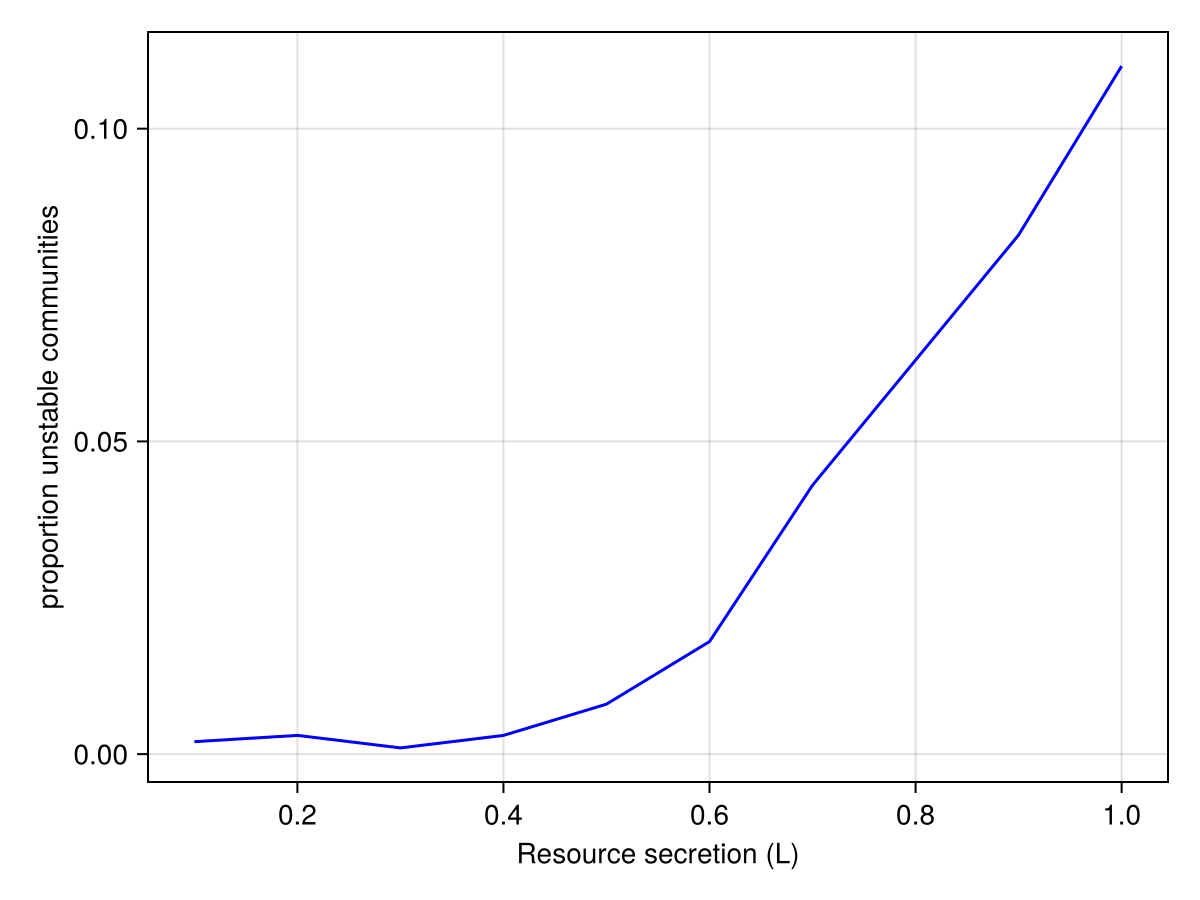

CairoMakie.Screen{IMAGE}


In [13]:
# plot prop vs sizes
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="Resource secretion (L)", ylabel="proportion unstable communities")
lines!(ax, sizes, total_pct; color=:blue)
display(fig)

In [44]:
println("Proportion of unstable communities: ", prop)

Proportion of unstable communities: [0.015873015873015872, 0.06204379562043796, 0.06610576923076923, 0.10246913580246914, 0.1071863580998782, 0.10922330097087378, 0.1158021712907117, 0.1192443919716647, 0.1385176184690158, 0.13110846245530394, 0.12180974477958237, 0.12252042007001167, 0.11251435132032148, 0.11467889908256881, 0.10896708286038592, 0.11350737797956867, 0.10279329608938548, 0.10236220472440945, 0.11858608893956671, 0.1334867663981588]


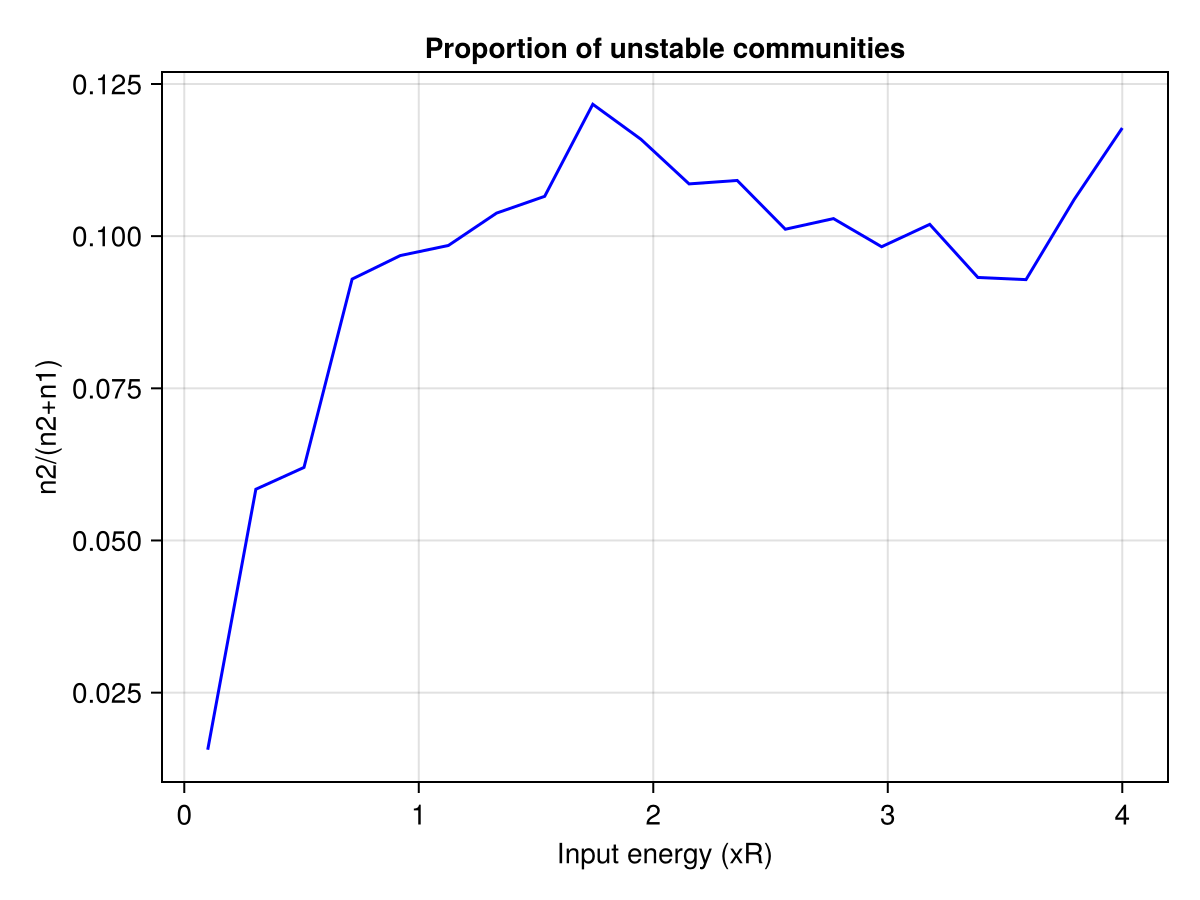

CairoMakie.Screen{IMAGE}


In [40]:
# plot prop vs sizes
fig = Figure()
ax = Axis(fig[1, 1]; title="Proportion of unstable communities", xlabel="Input energy (xR)", ylabel="n2/(n2+n1)")
lines!(ax, sizes, adj_pct; color=:blue)
display(fig)

In [ ]:
# Static resource size, variable species pool
npts = 10
sizes = LinRange(2, 30, npts)
R = 15
prop = fill(0., npts)

for i in 1:npts
    sz = Int64(ceil(sizes[i]))
    #println("size: ", sz)
    rsg = func(sz,R,0.2, 2, 0.9, 0.1, 0.3, 0.3)

    xx,prms,sses = do_rg_run2(rsg, 1000, 50,1000;
        maxresidthr=1e-8,
        tol=1e-11,
        return_int=(2, )
    )
    
    prop[i] = sum(xx .== 2) / length(xx)
    #println("size: ", sz, " prop: ", prop[i])
    
end

┌ Warning: maxresid reached is 8.80623 which is above the error threshold of 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:88
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/st

In [ ]:
# plot prop vs sizes
fig = Figure()
ax = Axis(fig[1, 1]; title="Proportion of unstable communities, R = 10", xlabel="community size (S)", ylabel="Proportion")
lines!(ax, sizes, prop; color=:blue)
display(fig)

In [ ]:
# Static species pool size, variable resource pool
npts = 10
sizes = LinRange(2, 30, npts)
N = 15
prop = fill(0., npts)

for i in 1:npts
    sz = Int64(ceil(sizes[i]))
    #println("size: ", sz)
    rsg = func(N,sz,0.2, 2, 0.9, 0.1, 0.3, 0.3)

    xx,prms,sses = do_rg_run2(rsg, 1000, 50,1000;
        maxresidthr=1e-8,
        tol=1e-11,
        return_int=(2, )
    )
    
    prop[i] = sum(xx .== 2) / length(xx)
    #println("size: ", sz, " prop: ", prop[i])
    
end

In [ ]:
# plot prop vs sizes
fig = Figure()
ax = Axis(fig[1, 1]; title="Proportion of unstable communities, N = 10", xlabel="number of resources (R)", ylabel="Proportion")
lines!(ax, sizes, prop; color=:blue)
display(fig)

## Sparsity o'clock

In [23]:
# Static species pool size, variable resource pool
npts = 10
sizes = LinRange(0.1, 1, npts)
N = R = 10
prop = fill(0., npts)

for i in 1:npts
    sz = sizes[i]
    #println("size: ", sz)
    rsg = func(N,R,0.2, 2, 0.9, sz, 0.3, 0.3)

    xx,prms,sses = do_rg_run2(rsg, 1000, 50,1000;
        maxresidthr=1e-8,
        tol=1e-11,
        return_int=(2, )
    )
    
    prop[i] = sum(xx .== 2) / length(xx)
    #println("size: ", sz, " prop: ", prop[i])
    
end

┌ Warning: maxresid reached is 1.08491e-08 > 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:92
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciM

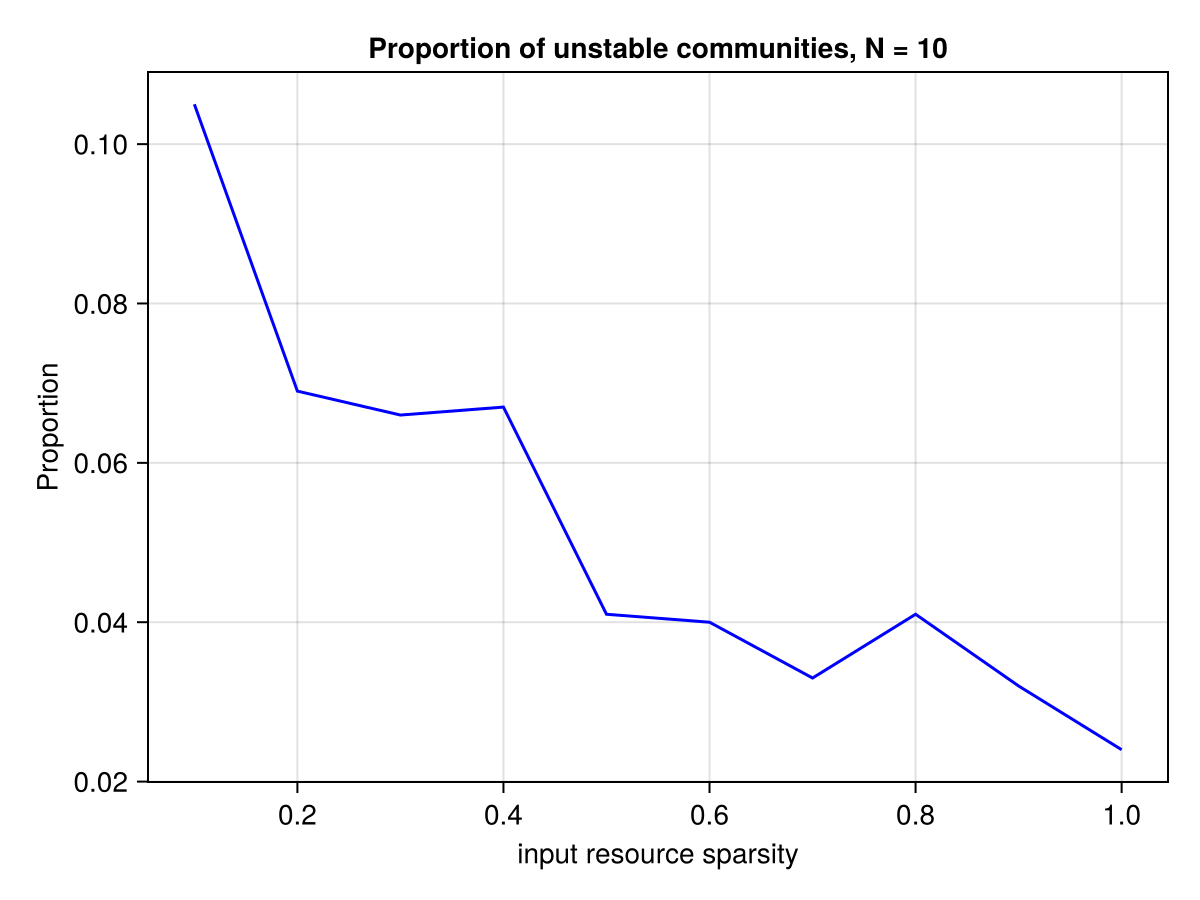

CairoMakie.Screen{IMAGE}


In [24]:
fig = Figure()
ax = Axis(fig[1, 1]; title="Proportion of unstable communities, N = 10", xlabel="input resource sparsity", ylabel="Proportion")
lines!(ax, sizes, prop; color=:blue)
display(fig)

In [25]:
npts = 10
sizes = LinRange(0.1, 1, npts)
N = R = 10
prop = fill(0., npts)

for i in 1:npts
    sz = sizes[i]
    #println("size: ", sz)
    rsg = func(N,R,0.2, 2, 0.9, 0.1, sz, 0.3)

    xx,prms,sses = do_rg_run2(rsg, 1000, 50,1000;
        maxresidthr=1e-8,
        tol=1e-11,
        return_int=(2, )
    )
    
    prop[i] = sum(xx .== 2) / length(xx)
    #println("size: ", sz, " prop: ", prop[i])
    
end

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm

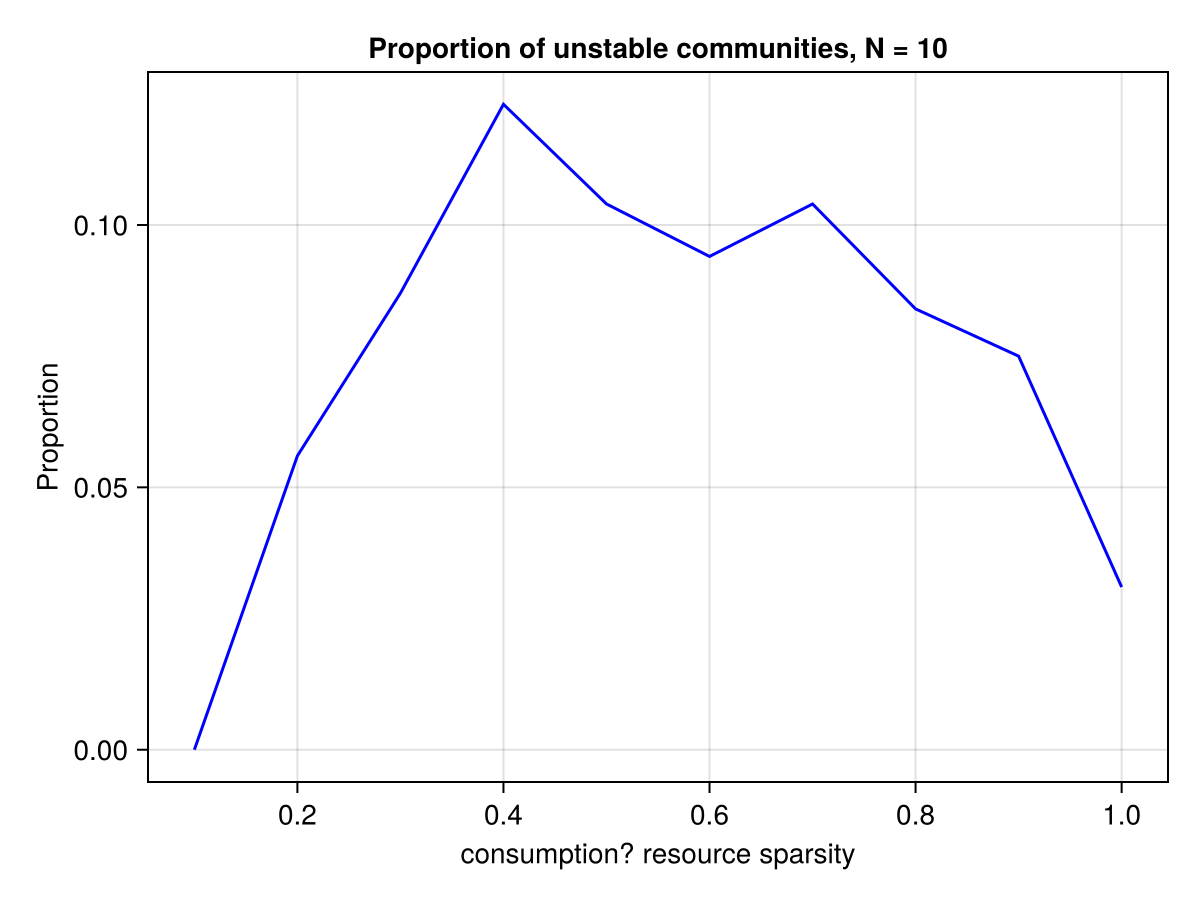

CairoMakie.Screen{IMAGE}


In [26]:
fig = Figure()
ax = Axis(fig[1, 1]; title="Proportion of unstable communities, N = 10", xlabel="consumption? resource sparsity", ylabel="Proportion")
lines!(ax, sizes, prop; color=:blue)
display(fig)

In [27]:
npts = 10
sizes = LinRange(0.1, 1, npts)
N = R = 10
prop = fill(0., npts)

for i in 1:npts
    sz = sizes[i]
    #println("size: ", sz)
    rsg = func(N,R,0.2, 2, 0.9, 0.1, 0.3, sz)

    xx,prms,sses = do_rg_run2(rsg, 1000, 50,1000;
        maxresidthr=1e-8,
        tol=1e-11,
        return_int=(2, )
    )
    
    prop[i] = sum(xx .== 2) / length(xx)
    #println("size: ", sz, " prop: ", prop[i])
    
end

┌ Warning: maxresid reached is 5.73633e-08 > 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:92
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciM

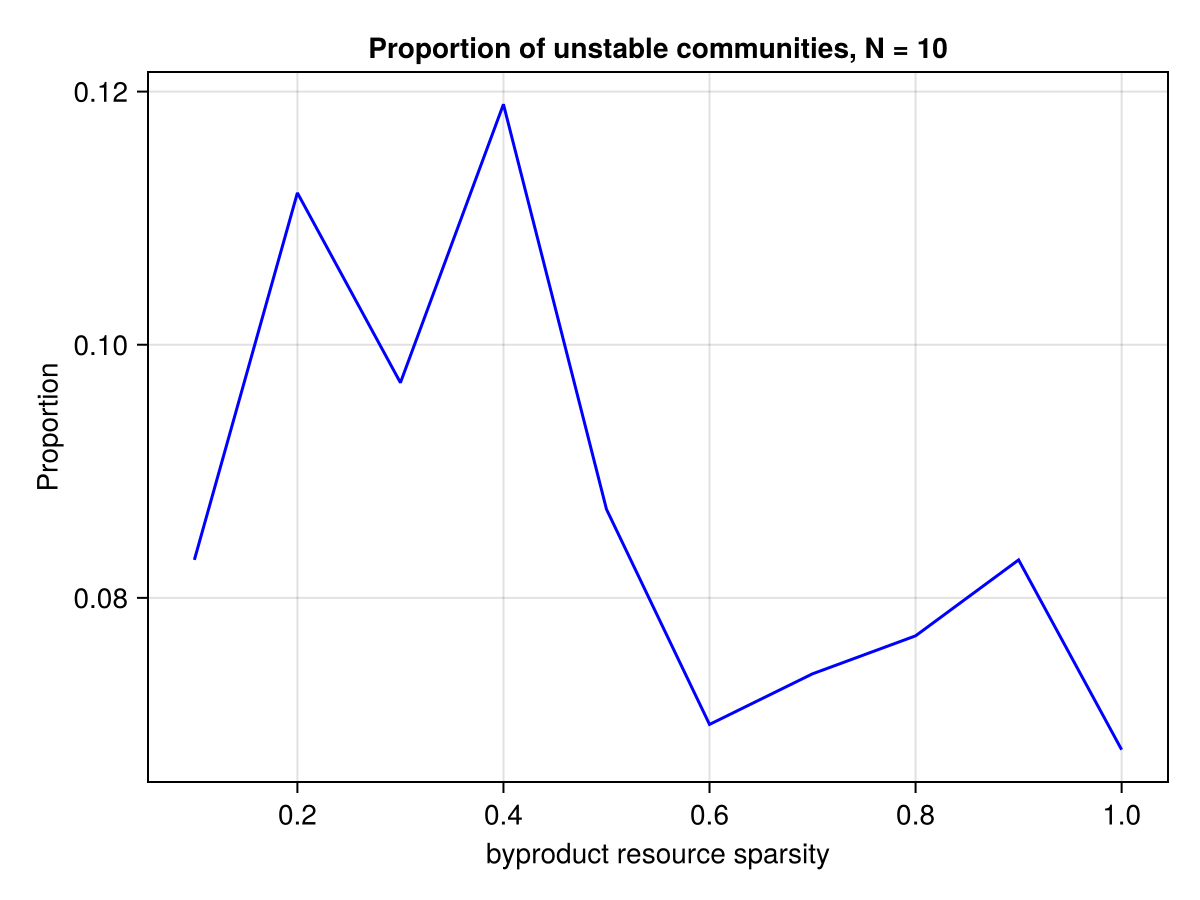

CairoMakie.Screen{IMAGE}


In [28]:
fig = Figure()
ax = Axis(fig[1, 1]; title="Proportion of unstable communities, N = 10", xlabel="byproduct resource sparsity", ylabel="Proportion")
lines!(ax, sizes, prop; color=:blue)
display(fig)